# Pedestrian classification
Erik Matovič and Jakub Horvat

[Dataset](https://data.nvision2.eecs.yorku.ca/PIE_dataset/)

### 0. Imports

In [119]:
import wandb
from pprint import pprint
import numpy as np
import pandas as pd
import torch 
from torch import flatten
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from utils import split_train_val
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot as plt
from os import listdir
from os.path import join
from pie_data import PIE
from PIL import Image

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(use_cuda, device)

True cuda:0


In [26]:
wandb.login()

api = wandb.Api()
sweep = api.sweep("xmatovice/uncategorized/1stel95e")

best_config = sweep.best_run().config
pprint(best_config)

wandb.init(config=best_config, project='uncategorized', name='NSIETE_zad1_final')
config = wandb.config

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Sorting runs by -summary_metrics.validation_accuracy


{'batch_size': 128,
 'dense1': 256,
 'epochs': 100,
 'learning_rate': 0.03648030109469176}


### 1. EDA
 - in [Exploratory Data Analysis](./EDA.ipynb)
 
### 2. Data preprocessing

In [2]:
#from pie_data import PIE

pie_path = '../' #'/media/erik/T7/DP/PIE_data' # <path_to_the_root_folder>
pie = PIE(data_path=pie_path)
type(pie)

pie_data.PIE

In [3]:
pie._images_path

'../images'

In [135]:
class PIE_dataset(Dataset):
    """
    Dataset class for dataloader.
    """
    def __init__(self, setname: str, pie: PIE) -> None:
        """
        Dataset init.
        :param setname: specifying trainig, validation or test set
        """
        assert setname in ['train', 'val', 'test'], 'wrong setname, accepting only \'train\', \'val\', \'test\''
        
        super().__init__()
        self.setname = setname
        self.img_path = pie._images_path + '/' + self.setname + '/'
        self.annotations_path = '../' + self.setname + '_annotations.csv'
        self.all_filenames = listdir(self.img_path)
        self.all_annotations = pd.read_csv(self.annotations_path)     
        self.all_annotations_meaning = self.all_annotations.columns.values.tolist()
        # Setting labels
        self.label_action = train_dataset.all_annotations['action']
        self.label_gesture = train_dataset.all_annotations['gesture']
        self.label_look = train_dataset.all_annotations['look']
        self.label_cross = train_dataset.all_annotations['cross']   
        
    
    def __len__(self) -> int:
        """
        Return the total number of images.
        returns: The total number of images.
        """
        return len(self.all_filenames)
    

    def __getitem__(self, index) -> dict:
        """
        Get item with annotations.
        :param index: the number of image
        returns: Dictionary.
        """
        file_name = self.all_filenames[index]
        img_path = self.img_path + file_name
        # Read the input image
        img = Image.open(img_path).convert('RGB')
        # convert image to torch tensor
        img_tensor = transforms.ToTensor()(img)
        # Transform to normalize the image with mean and std of the ImageNet dataset
        transform = transforms.Normalize(mean=(0.5,), std=(0.5,))
        normalized_img_tensor = transform(img_tensor)
        # convert the normalized tensor to PIL image
        # normalized_img = transforms.ToPILImage()(normalized_img_tensor)
        # normalized_img.show()

        #print(index, img_path[40:], img_path)
        # pedestrian index is varying from index 38 to 41
        ped_index = img_path.index('_', 38)

        set_name = img_path[16:21]
        video_name = img_path[22:32]
        ped_name = img_path[33:ped_index]
        frame_name = img_path[ped_index + 1:]

        label = train_dataset.all_annotations.loc[
            (train_dataset.all_annotations.set == set_name) &
            (train_dataset.all_annotations.video == video_name) &
            (train_dataset.all_annotations.frame == frame_name) &
            (train_dataset.all_annotations.ped == ped_name)
        ]

        label_action = torch.tensor(self.label_action[label.index[0]], dtype=torch.long)
        label_gesture = torch.tensor(self.label_gesture[label.index[0]], dtype=torch.long)
        label_look = torch.tensor(self.label_look[label.index[0]], dtype=torch.long)
        label_cross = torch.tensor(self.label_cross[label.index[0]], dtype=torch.long)
        
        return {'data': normalized_img_tensor,
                'label_action': label_action,
                'label_gesture': label_gesture,
                'label_look': label_look,
                'label_cross': label_cross,
                'img_idx': index}

In [136]:
train_dataset = PIE_dataset('train', pie)
val_dataset = PIE_dataset('val', pie)
test_dataset = PIE_dataset('test', pie)

In [137]:
train_dataset.__getitem__(22)

{'data': tensor([[[-0.6314, -0.6314, -0.6392,  ..., -0.7961, -0.8039, -0.8039],
          [-0.6471, -0.6471, -0.6471,  ..., -0.7961, -0.8039, -0.8039],
          [-0.6549, -0.6549, -0.6549,  ..., -0.7961, -0.8039, -0.8039],
          ...,
          [-0.2235, -0.2235, -0.2314,  ..., -0.3098, -0.2941, -0.2941],
          [-0.2627, -0.2627, -0.2627,  ..., -0.1686, -0.1608, -0.1608],
          [-0.2784, -0.2784, -0.2784,  ..., -0.0196, -0.0118, -0.0118]],
 
         [[-0.6314, -0.6314, -0.6392,  ..., -0.7961, -0.8039, -0.8039],
          [-0.6471, -0.6471, -0.6471,  ..., -0.7961, -0.8039, -0.8039],
          [-0.6549, -0.6549, -0.6549,  ..., -0.7961, -0.8039, -0.8039],
          ...,
          [-0.2235, -0.2235, -0.2314,  ..., -0.3098, -0.2941, -0.2941],
          [-0.2627, -0.2627, -0.2627,  ..., -0.1686, -0.1608, -0.1608],
          [-0.2784, -0.2784, -0.2784,  ..., -0.0196, -0.0118, -0.0118]],
 
         [[-0.6314, -0.6314, -0.6392,  ..., -0.7961, -0.8039, -0.8039],
          [-0.6471, 

In [8]:
train_dataset.all_filenames

['set04_video_0010_4_10_1476_00535.png',
 'set04_video_0013_4_13_1638_01748.png',
 'set04_video_0007_4_7_1285_00180.png',
 'set04_video_0011_4_11_1523_00622.png',
 'set04_video_0008_4_8_1371_01340.png',
 'set04_video_0008_4_8_1371_01339.png',
 'set02_video_0003_2_3_198_01172.png',
 'set04_video_0009_4_9_1421_04039.png',
 'set02_video_0003_2_3_198_01165.png',
 'set02_video_0003_2_3_197_01171.png',
 'set04_video_0009_4_9_1421_04041.png',
 'set01_video_0002_1_2_53_04698.png',
 'set04_video_0006_4_6_1232_02217.png',
 'set01_video_0001_1_1_1_01134.png',
 'set04_video_0008_4_8_1371_01336.png',
 'set02_video_0003_2_3_198_01166.png',
 'set04_video_0005_4_5_1206_04342.png',
 'set04_video_0011_4_11_1523_00626.png',
 'set04_video_0012_4_12_1543_00312.png',
 'set04_video_0004_4_4_1169_00282.png',
 'set04_video_0011_4_11_1524_00621.png',
 'set04_video_0006_4_6_1233_02229.png',
 'set04_video_0006_4_6_1232_02219.png',
 'set04_video_0011_4_11_1523_00625.png',
 'set04_video_0013_4_13_1637_01734.png',
 

In [9]:
train_dataset.all_annotations_meaning

['Unnamed: 0',
 'set',
 'video',
 'frame',
 'ped_idx',
 'ped',
 'BBox',
 'action',
 'gesture',
 'look',
 'cross']

In [69]:
len(train_dataset)

628

In [138]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True) #, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False) #, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=True) #, num_workers=4)

In [82]:
train_dataloader.dataset

Show images

(-0.5, 325.5, 325.5, -0.5)

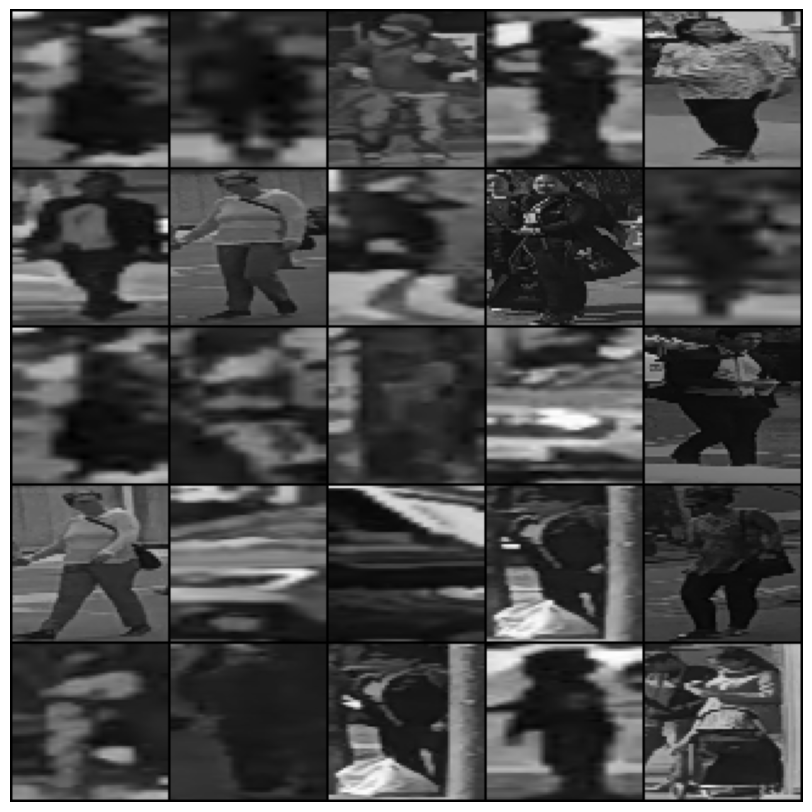

In [141]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)

#Plotting 25 images from the 1st batch 
dataiter = iter(train_dataloader)
sample = next(dataiter)

images, y_batch_action, y_batch_gesture, \
            y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                sample['label_gesture'], sample['label_look'], sample['label_cross'], \
                    sample['img_idx']

plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

## 3. Model

In [142]:
class CNN(nn.Module):
    """
    Model class
    """
    def __init__(self, n_channels) -> None:
        """
        init
        :param n_channels: number of input challens
        """
        super(CNN, self).__init__()
        # initialize first set of CONV => RELU => CONV => RELU => POOL layers
        self.conv11 = nn.Conv2d(in_channels=n_channels, out_channels=32, # 62 
                             kernel_size=(3, 3))
        #self.relu11 = nn.ReLU()
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=32, #60
			    kernel_size=(3, 3))
        #self.relu12 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #30

		# initialize second set of CONV => RELU => CONV => RELU => POOL layers
        self.conv21 = nn.Conv2d(in_channels=32, out_channels=64, #28
			kernel_size=(5, 5))
        #self.relu21 = nn.ReLU()
        self.conv22 = nn.Conv2d(in_channels=64, out_channels=64, #26
			kernel_size=(3, 3))
        #self.relu22 = nn.ReLU()
        # self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #13

        # MLP
        # initialize first set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=9216, out_features=5*128) #preco 9216?
        self.relu = nn.ReLU()

		# initialize second set of FC => RELU layers
        self.fc2 = nn.Linear(in_features=5*128, out_features=4*128)
        #self.relu3 = ReLU()

        self.fc_action = nn.Linear(512, 2)      # output action class
        self.fc_gesture = nn.Linear(512, 3)     # output gesture class
        self.fc_look = nn.Linear(512, 2)        # output look class
        self.fc_cross = nn.Linear(512, 2)       # output cross class

		# initialize our softmax classifier
        #self.fc3 = nn.Linear(in_features=5*128, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1) #dim=1 je ze to robi po riadkoch


    def forward(self, x) -> dict:        
        """
        forward pass
        :param x: data x
        """
        # pass the input through our first set of CONV => RELU =>
		# POOL layers
        output = self.conv11(x)
        output = self.relu(output)
        output = self.conv12(output)
        output = self.relu(output)
        output = self.maxpool(output)

		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
        output = self.conv21(output)
        output = self.relu(output)
        output = self.conv22(output)
        output = self.relu(output)
        output = self.maxpool(output)

		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
        output = flatten(output, 1)
		#print("after flatten ", output)
        output = self.fc1(output)
        output = self.relu(output)
		
        # pass the output to our softmax classifier to get our output
		# predictions
        output = self.fc2(output)
        output = self.relu(output)

        label_action = self.fc_action(output)
        label_gesture = self.fc_gesture(output) # torch.sigmoid(self.fc2(X))  
        label_look = self.fc_look(output)
        label_cross = self.fc_cross(output)

        label_action = self.logSoftmax(label_action)
        label_gesture = self.logSoftmax(label_gesture)
        label_look = self.logSoftmax(label_look)
        label_cross = self.logSoftmax(label_cross)
        
        # return 4 classes
        return {'label_action': label_action,
                'label_gesture': label_gesture,
                'label_look': label_look,
                'label_cross': label_cross}

## 4. training & validation

In [117]:
n_epochs = 50
for epoch in range(n_epochs):
    for _, sample in enumerate(train_dataloader):
        # get X and y with index from sample
        X_batch, y_batch_action, y_batch_gesture, \
            y_batch_look, y_batch_cross, idx = sample['data'], sample['label_action'], \
                sample['label_gesture'], sample['label_look'], sample['label_cross'], \
                    sample['img_idx']

        print(epoch, idx)

0 tensor([296, 545, 330, 524, 190, 225, 312, 498,  25, 378, 416, 427, 560, 373,
        618, 624, 253, 552, 457, 317,  90, 278, 197,  28, 597, 189, 614, 615,
        268, 625,  52, 287,  96, 598,  45, 165, 274, 322, 558,  54, 230, 355,
        374, 465, 409,  53, 554, 124, 455,   4,  21, 513,  84, 450, 472, 164,
        363, 201, 445, 408,  91, 347,  26, 425])
0 tensor([458, 627, 463, 505, 217, 244, 237, 570, 616, 128, 155, 306, 596, 379,
        603, 293, 393,   7, 129, 391, 290,  58, 102, 584, 580, 426, 192, 146,
        320, 351,  74, 140, 418, 593, 340,  18, 154,  80, 345,  36, 553, 222,
        261, 200, 123, 375, 258, 623,  94, 233, 232, 171, 250, 298, 236, 462,
        106, 354, 319, 419, 557, 619, 461, 547])
0 tensor([208, 341, 294, 369, 175, 361, 218, 421, 339, 133, 575, 259, 297,  23,
        359, 551, 303,  63, 194, 145, 605, 288,  78, 518, 555, 600, 187, 566,
         72, 599, 400, 168, 405, 285, 377, 402, 613,  17,  99, 289, 162, 438,
        262, 308,  79, 538, 412,  75, 

KeyboardInterrupt: 

In [39]:
learning_rate = best_config['learning_rate']    #  # 0.001 
input_size = 20                         # number of features
hidden_size = best_config['dense1']        #  #64         # number of features in hidden state
num_classes = 4                 # number of output classes 

n_epochs = best_config['epochs']        
batch_size = 512  

mlp = MLP( 
    n_inputs=input_size, 
    n_classes=num_classes,
    lr=learning_rate,
    hidden_size=hidden_size)
mlp.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

In [40]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    return correct


def train_mlp(n_epochs, mlp, optimizer, loss_fn, 
              train_dl, val_dl, device, batch_size):
    # init train lists for statistics
    loss_train, accuracy_train = list(), list()

    # init validation lists for statistics
    loss_validation, accuracy_validation = list(), list()

    # enumerate epochs
    for epoch in range(n_epochs):
        # init epoch train counters
        epoch_train_accuracy, epoch_train_total, epoch_train_true, epoch_train_loss = 0, 0, 0, 0

        # init epoch validation counters
        epoch_validation_accuracy, epoch_validation_total, \
            epoch_validation_true, epoch_validation_loss = 0, 0, 0, 0

        # enumerate mini batches
        for idx, (X_batch, y_batch) in enumerate(train_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            # Make prediction logits with model
            y_logits = mlp(X_batch)
            # Perform softmax calculation on logits across dimension 1 to get prediction probabilities
            y_pred_probs = torch.softmax(y_logits, dim=1) 
            # go from logits -> prediction probabilities -> prediction labels
            y_pred = torch.argmax(y_pred_probs, dim=1) 
            
            loss = loss_fn(y_logits, y_batch)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

            # update train counters
            epoch_train_loss += loss.item()
            epoch_train_true += accuracy_fn(y_batch, y_pred)
            epoch_train_total += len(y_batch)
        
        # update train accuracy & loss statistics
        epoch_train_accuracy = (epoch_train_true/epoch_train_total) * 100
        epoch_train_loss /= (len(train_dl.dataset)/train_dl.batch_size) #batch_size)

        # disable gradient calculation
        with torch.no_grad():
            # enumerate mini batches
            for idx, (X_batch, y_batch) in enumerate(val_dl):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # compute the models output
                test_logits = mlp(X_batch)
                test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
                # calculate loss
                loss = loss_fn(test_logits, y_batch)

                # update validation counters
                epoch_validation_loss += loss.item()
                epoch_validation_true += accuracy_fn(y_batch, test_pred)
                epoch_validation_total += len(y_batch)
        
        # update validation accuracy & loss statistics
        epoch_validation_accuracy = (epoch_validation_true/epoch_validation_total) * 100
        epoch_validation_loss /= (len(val_dl.dataset)/val_dl.batch_size) #batch_size)

        # update global epochs statistics
        loss_train.append(epoch_train_loss)
        accuracy_train.append(epoch_train_accuracy)
        loss_validation.append(epoch_validation_loss)
        accuracy_validation.append(epoch_validation_accuracy)

        # print
        if epoch == (n_epochs - 1):
            print(
                f'Epoch {epoch}/{n_epochs}: \
                train loss {loss_train[-1]}, \
                validation loss {loss_validation[-1]}, \
                train accuracy {accuracy_train[-1]}, \
                validation accuracy {accuracy_validation[-1]}'
            )

    return loss_train, accuracy_train, loss_validation, accuracy_validation

In [41]:
def evaluation(mlp, test_dl):

    y_pred_all, y_test_all = list(), list()

    #total = 0
    #correct = 0

    with torch.no_grad():
        for X_batch, y_batch in test_dl:
            # outputs = mlp(X_batch)
            # evaluate on test set
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_hat = mlp(X_batch)
            test_pred = torch.softmax(y_hat, dim=1).argmax(dim=1)
            epoch_validation_true += accuracy_fn(y_batch, test_pred)
            
            y_pred_all.extend(test_pred.cpu().numpy())
            y_test_all.extend(y_batch.cpu().numpy())
        epoch_validation_true = (epoch_validation_true / len(test_dl.dataset)) * 100
    
    print('acc:', epoch_validation_true)
    report = classification_report(y_test_all, y_pred_all, target_names=['0', '1', '2', '3'], digits=4)
    print(report)

In [42]:
loss_train, accuracy_train, loss_validation, accuracy_validation = \
    train_mlp(
        n_epochs=n_epochs,
        mlp=mlp,
        optimizer=optimizer,
        loss_fn=loss_fn,
        train_dl=train_dl,
        val_dl=val_dl,
        device=device,
        batch_size=batch_size
    )

Epoch 99/100:                 train loss 0.6336436424726322,                 validation loss 0.7231514400906033,                 train accuracy 75.4320987654321,                 validation accuracy 82.22222222222221


In [43]:
y_pred_all, y_test_all = list(), list()

total = 0
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_dl:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_hat = mlp(X_batch)
        test_pred = torch.softmax(y_hat, dim=1).argmax(dim=1)
        epoch_validation_true = accuracy_fn(y_batch, test_pred)
        
        print('Accuracy epoch: %.3f' % ((epoch_validation_true / len(y_batch)) * 100))
        y_pred_all.extend(test_pred.cpu().numpy())
        y_test_all.extend(y_batch.cpu().numpy())
        correct += epoch_validation_true


print('Accuracy total: %.3f' % ((correct / len(test_dl.dataset)) * 100))
report = classification_report(y_test_all, y_pred_all, target_names=['0', '1', '2', '3'], output_dict=True)

Accuracy epoch: 79.688
Accuracy epoch: 84.722
Accuracy total: 81.500


In [44]:
pprint(report)

{'0': {'f1-score': 0.8429752066115702,
       'precision': 0.8793103448275862,
       'recall': 0.8095238095238095,
       'support': 63},
 '1': {'f1-score': 0.7735849056603773,
       'precision': 0.7192982456140351,
       'recall': 0.8367346938775511,
       'support': 49},
 '2': {'f1-score': 0.7631578947368423,
       'precision': 0.8529411764705882,
       'recall': 0.6904761904761905,
       'support': 42},
 '3': {'f1-score': 0.865979381443299,
       'precision': 0.8235294117647058,
       'recall': 0.9130434782608695,
       'support': 46},
 'accuracy': 0.815,
 'macro avg': {'f1-score': 0.8114243471130221,
               'precision': 0.818769794669229,
               'recall': 0.8124445430346051,
               'support': 200},
 'weighted avg': {'f1-score': 0.8145039075961327,
                  'precision': 0.8217402405608341,
                  'recall': 0.815,
                  'support': 200}}


<Figure size 1850x1050 with 0 Axes>

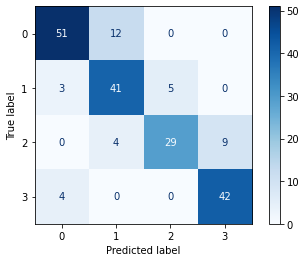

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)

matrix = confusion_matrix(y_test_all, y_pred_all)
matrix_display = ConfusionMatrixDisplay(matrix, display_labels=['0', '1', '2', '3'])
matrix_display.plot(cmap='Blues')

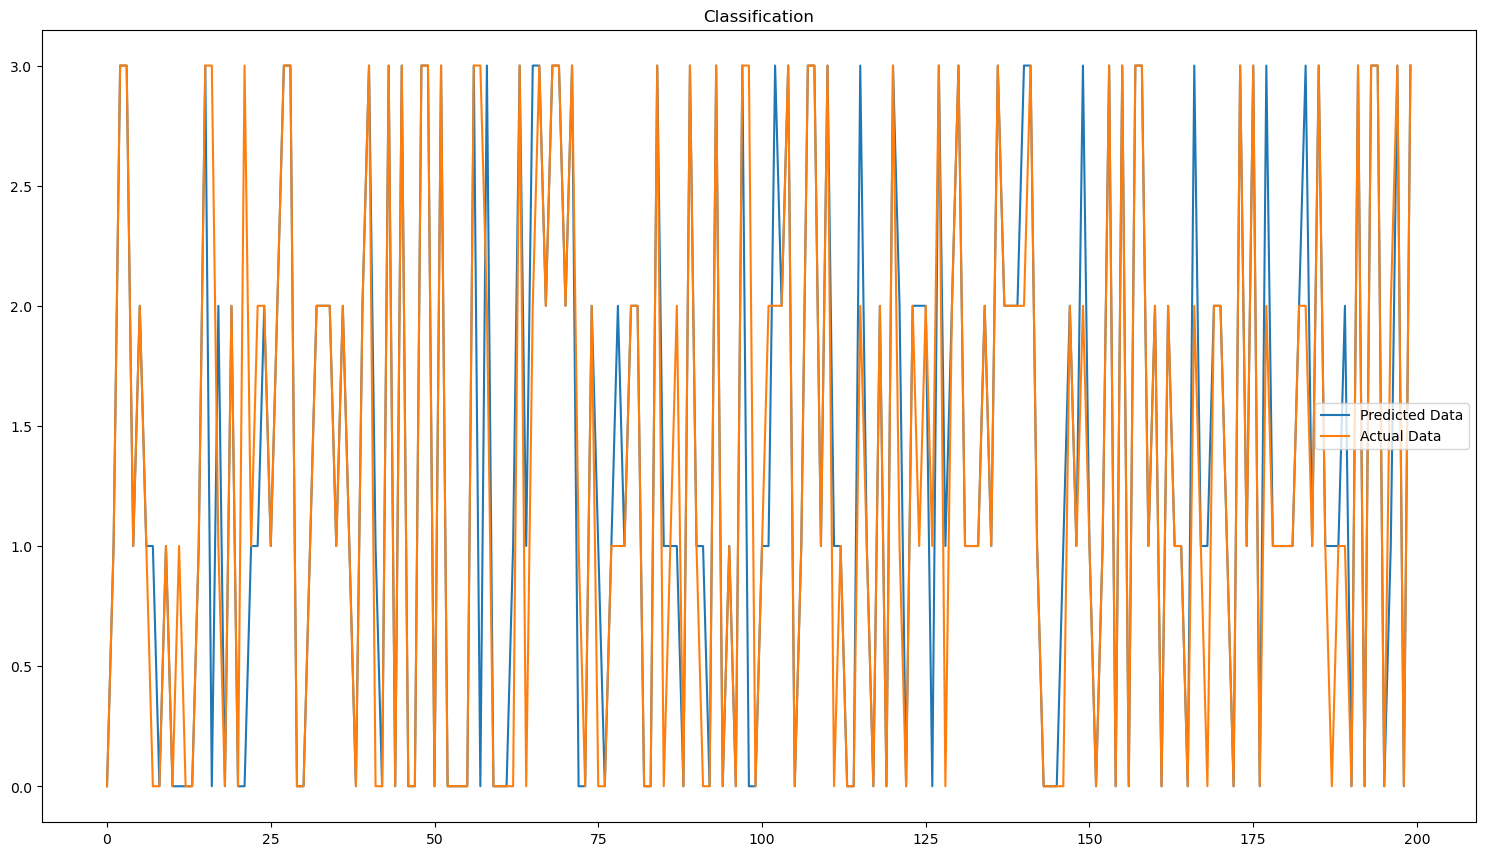

In [46]:
f = plt.figure(figsize=(10,6)) #plotting
f.set_size_inches(18.5, 10.5)
f.set_dpi(100)

plt.plot(y_pred_all, label='Predicted Data') # predicted plot
plt.plot(y_test_all, label='Actual Data') # actual plot
plt.title('Classification')
plt.legend()
plt.show() 

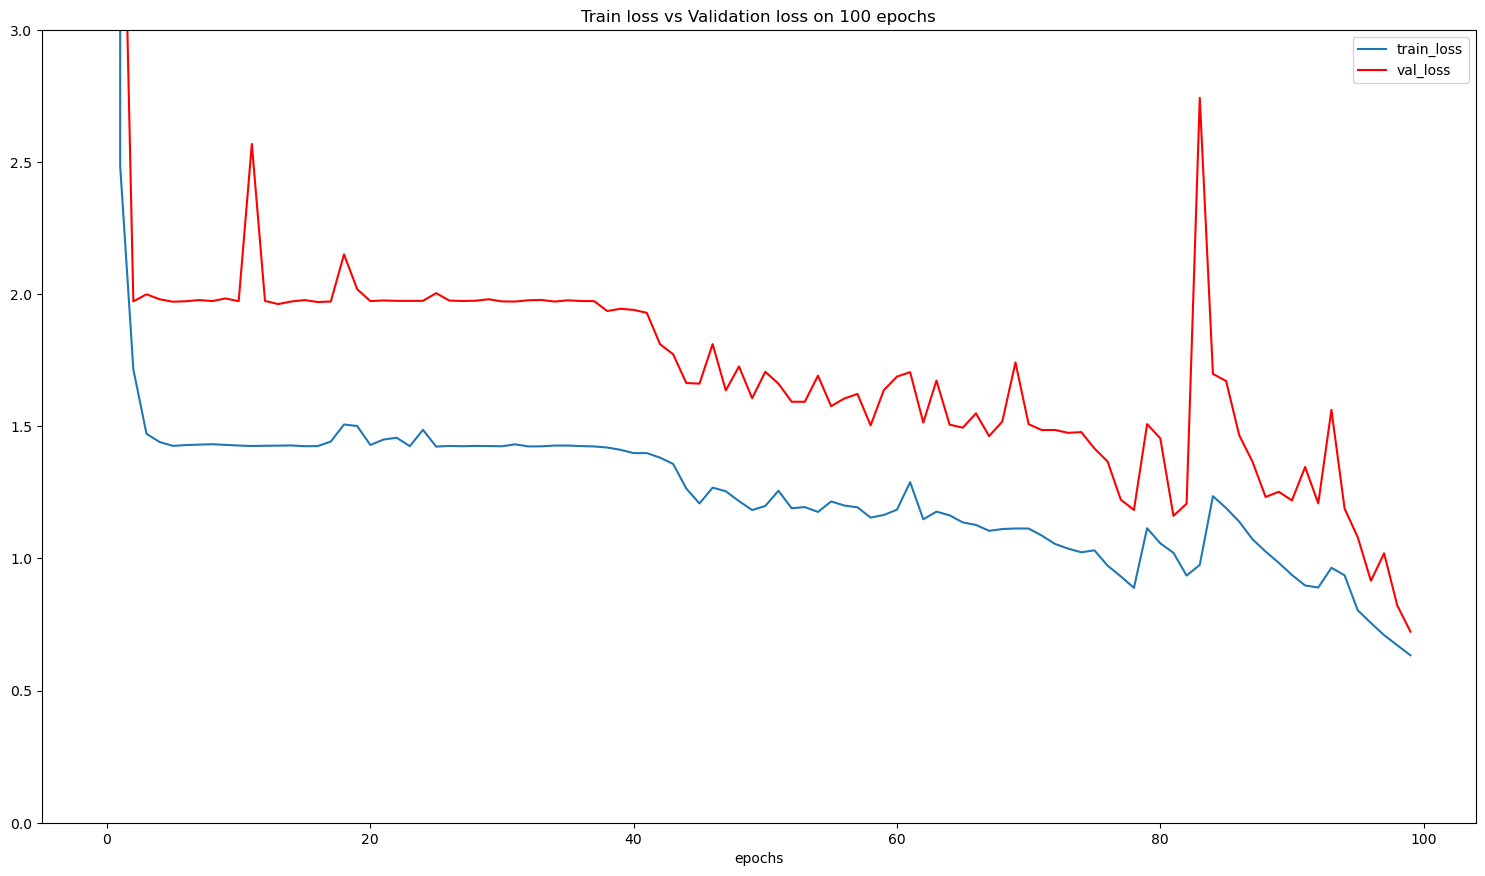

In [47]:

def plot_loss(train_loss, val_loss):
    '''
    Visualize training loss vs. validation loss.
    Parameters
    ----------
    train_loss: training loss
    val_loss: validation loss
    Returns: None
    -------
    '''
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    loss_csv = pd.DataFrame({"epochs": range(len(train_loss)), "train_loss": train_loss,
                             "val_loss": val_loss})
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    loss_csv.plot(kind='line',x='epochs',y='train_loss',ax=ax )
    loss_csv.plot(kind='line',x='epochs',y='val_loss', color='red', ax=ax)
    plt.title(f'Train loss vs Validation loss on {len(train_loss)} epochs')
    plt.ylim([0, 3])
    plt.show()
    # plt.savefig("../outputs/train_vs_val_loss.png")

# Examine results
plot_loss(loss_train, loss_validation)

[24.753086419753085, 27.34567901234568, 26.049382716049386, 25.617283950617285, 25.864197530864196, 25.0, 23.08641975308642, 27.098765432098766, 25.98765432098765, 23.827160493827158, 25.0, 24.074074074074073, 24.938271604938272, 24.87654320987654, 23.950617283950617, 24.444444444444443, 25.0, 23.88888888888889, 24.074074074074073, 25.123456790123456, 24.62962962962963, 25.493827160493826, 24.135802469135804, 25.679012345679013, 24.567901234567902, 26.111111111111114, 25.679012345679013, 24.938271604938272, 25.74074074074074, 25.679012345679013, 24.753086419753085, 24.074074074074073, 25.061728395061728, 25.74074074074074, 22.839506172839506, 23.765432098765434, 24.938271604938272, 24.691358024691358, 26.97530864197531, 27.962962962962962, 27.901234567901234, 26.41975308641975, 31.35802469135803, 31.419753086419753, 42.407407407407405, 43.82716049382716, 40.617283950617285, 42.839506172839506, 40.67901234567901, 44.074074074074076, 40.925925925925924, 42.839506172839506, 44.25925925925

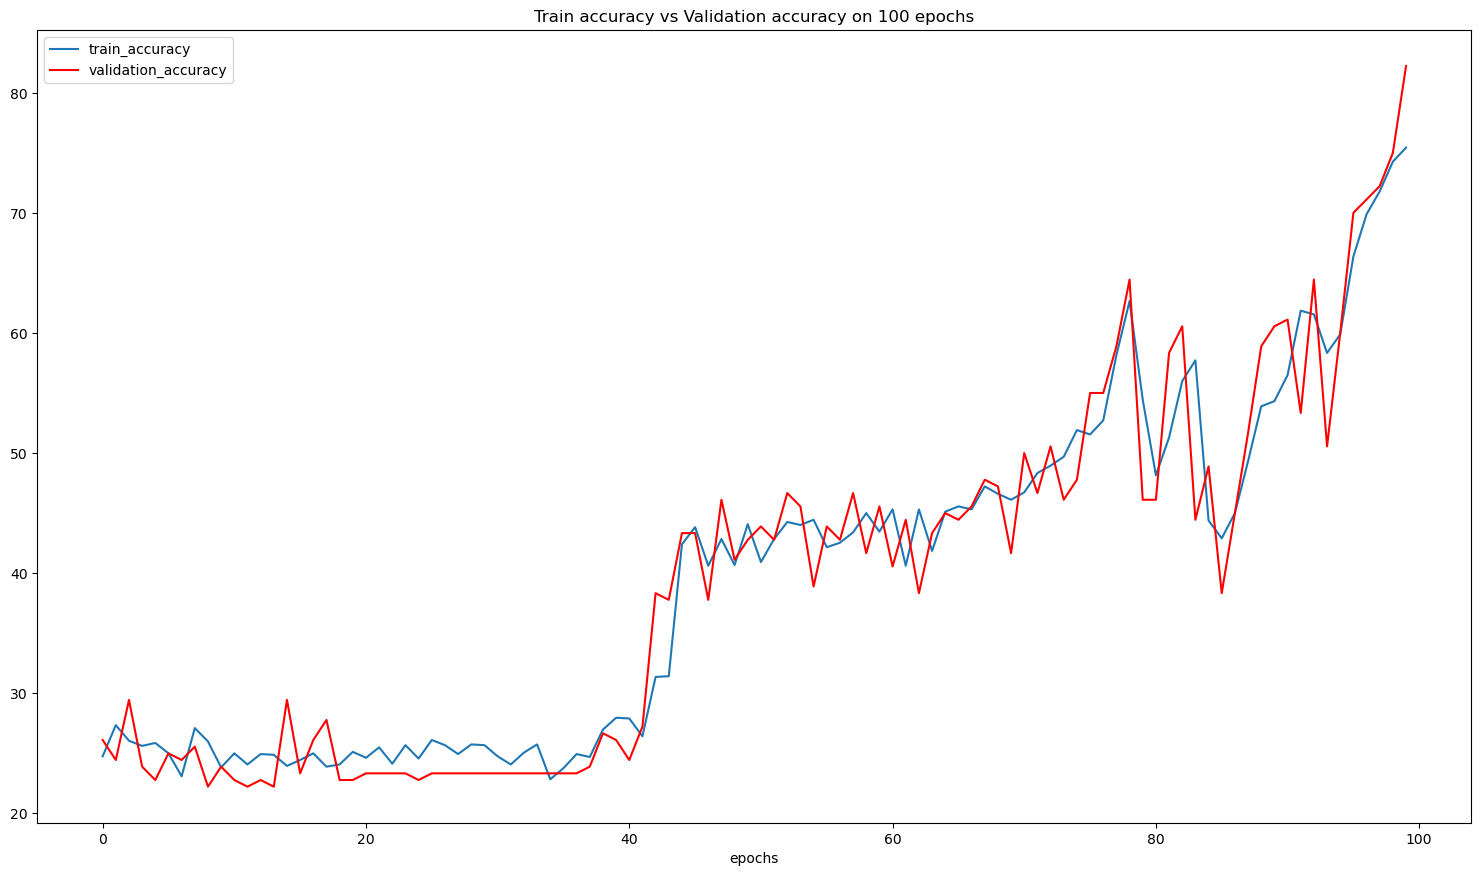

In [49]:
def plot_accuracy(train_accuracy, validation_accuracy):
    """
    TODO: refactor
    """
    f = plt.figure(figsize=(10,6)) #plotting
    f.set_size_inches(18.5, 10.5)
    f.set_dpi(100)

    accuracy_csv = pd.DataFrame({
        "epochs": range(len(train_accuracy)), 
        "train_accuracy": train_accuracy,
        "validation_accuracy": validation_accuracy
    })
    # loss_csv.to_csv("../outputs/loss.csv")
    # gca stands for 'get current axis'
    ax = plt.gca()
    accuracy_csv.plot(kind='line',x='epochs',y='train_accuracy', ax=ax)
    accuracy_csv.plot(kind='line',x='epochs',y='validation_accuracy', color='red', ax=ax)
    plt.title(f'Train accuracy vs Validation accuracy on {len(train_accuracy)} epochs')
    plt.show()

print(accuracy_train, accuracy_validation)
plot_accuracy(accuracy_train, accuracy_validation)